# kaggleのtitanicデータ（二値分類）

# ライブラリの読み込み

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import japanize_matplotlib

In [5]:
import seaborn as sns
sns.set()

# データの読み込み

In [6]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

Survival：0 = No, 1 = Yes

In [7]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train_raw.shape

(891, 12)

In [9]:
test_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
test_raw.shape

(418, 11)

In [11]:
train = train_raw.copy()
test = test_raw.copy()

In [12]:
train = train.drop('Survived', axis=1)
train['Survived'] = train_raw['Survived']
train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


# 基礎集計

(array([549.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 342.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

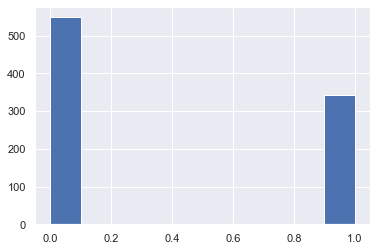

In [13]:
plt.hist(train['Survived'])

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [15]:
train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

## s1生き残り・s0死亡で比較

In [16]:
train_s0 = train[train['Survived']==0]
train_s0.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
count,549.000000,549.000000,549,549,424.000000,549.000000,549.000000,549,549.000000,68,549,549.0
unique,NaN,NaN,549,2,NaN,NaN,NaN,470,NaN,62,3,NaN
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,G6,S,NaN
freq,NaN,NaN,1,468,NaN,NaN,NaN,7,NaN,2,427,NaN
mean,447.016393,2.531876,NaN,NaN,30.626179,0.553734,0.329690,NaN,22.117887,NaN,NaN,0.0
std,260.640469,0.735805,NaN,NaN,14.172110,1.288399,0.823166,NaN,31.388207,NaN,NaN,0.0
min,1.000000,1.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.0
25%,211.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.854200,NaN,NaN,0.0
50%,455.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,10.500000,NaN,NaN,0.0
75%,675.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,26.000000,NaN,NaN,0.0


In [17]:
train_s1 = train[train['Survived']==1]
train_s1.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
count,342.000000,342.000000,342,342,290.000000,342.000000,342.000000,342,342.000000,136,340,342.0
unique,NaN,NaN,342,2,NaN,NaN,NaN,260,NaN,101,3,NaN
top,NaN,NaN,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,NaN,NaN,NaN,1601,NaN,B96 B98,S,NaN
freq,NaN,NaN,1,233,NaN,NaN,NaN,5,NaN,4,217,NaN
mean,444.368421,1.950292,NaN,NaN,28.343690,0.473684,0.464912,NaN,48.395408,NaN,NaN,1.0
std,252.358840,0.863321,NaN,NaN,14.950952,0.708688,0.771712,NaN,66.596998,NaN,NaN,0.0
min,2.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,1.0
25%,250.750000,1.000000,NaN,NaN,19.000000,0.000000,0.000000,NaN,12.475000,NaN,NaN,1.0
50%,439.500000,2.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,26.000000,NaN,NaN,1.0
75%,651.500000,3.000000,NaN,NaN,36.000000,1.000000,1.000000,NaN,57.000000,NaN,NaN,1.0


### age（年齢）

(array([36., 19., 63., 65., 52., 24., 21.,  9.,  0.,  1.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <BarContainer object of 10 artists>)

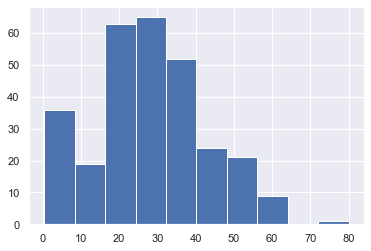

In [18]:
plt.hist(train_s1['Age'])

(array([ 18.,  16.,  99., 110.,  64.,  45.,  38.,  15.,  13.,   6.]),
 array([ 1. ,  8.3, 15.6, 22.9, 30.2, 37.5, 44.8, 52.1, 59.4, 66.7, 74. ]),
 <BarContainer object of 10 artists>)

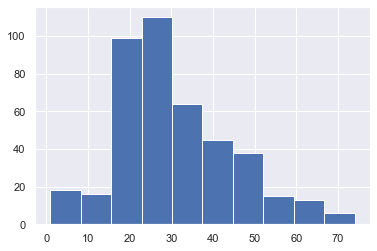

In [19]:
plt.hist(train_s0['Age'])

### Pclass（Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)）

(array([136.,   0.,   0.,   0.,   0.,  87.,   0.,   0.,   0., 119.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

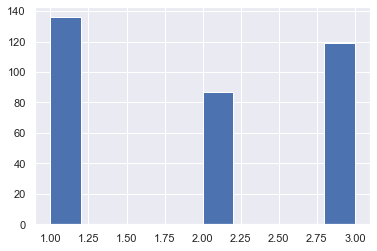

In [20]:
plt.hist(train_s1['Pclass'])

(array([ 80.,   0.,   0.,   0.,   0.,  97.,   0.,   0.,   0., 372.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

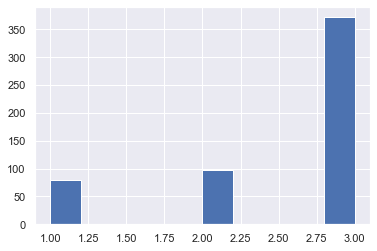

In [21]:
plt.hist(train_s0['Pclass'])

### sex（male or female）

(array([233.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 109.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

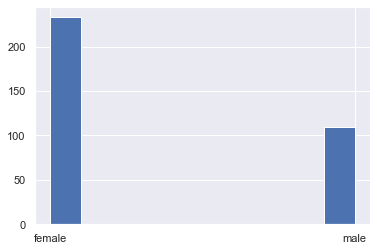

In [22]:
plt.hist(train_s1['Sex'])

(array([468.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  81.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

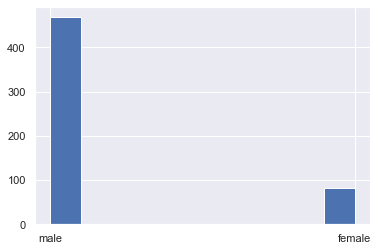

In [23]:
plt.hist(train_s0['Sex'])

### sibsp（Number of Siblings/Spouses Aboard）

Number of Siblings/Spouses Aboard　⇒　一緒に乗船した兄弟、配偶者の数

(array([210.,   0., 112.,   0.,   0.,  13.,   0.,   4.,   0.,   3.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

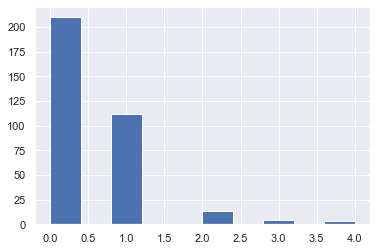

In [24]:
plt.hist(train_s1['SibSp'])

(array([398.,  97.,  15.,  12.,   0.,  15.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

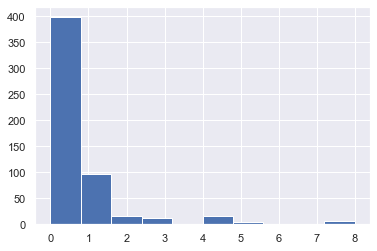

In [25]:
plt.hist(train_s0['SibSp'])

### parch（Number of Parents/Children Aboard）

Number of Parents/Children Aboard　⇒　一緒に乗船した親子の数

(array([233.,   0.,  65.,   0.,  40.,   0.,   3.,   0.,   0.,   1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

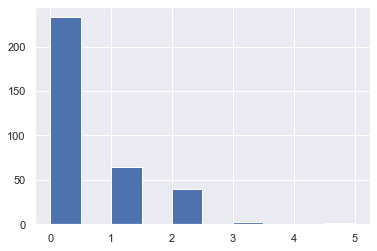

In [26]:
plt.hist(train_s1['Parch'])

(array([445.,  53.,   0.,  40.,   0.,   2.,   4.,   0.,   4.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

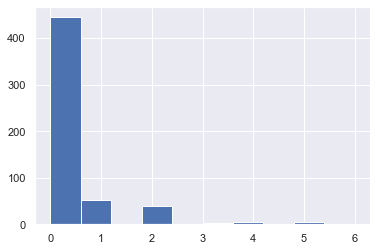

In [27]:
plt.hist(train_s0['Parch'])

### fare（Passenger fare）

(array([233.,  70.,  23.,   2.,   7.,   4.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <BarContainer object of 10 artists>)

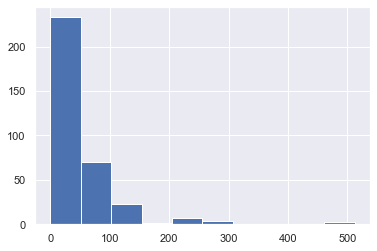

In [28]:
plt.hist(train_s1['Fare'])

(array([421.,  83.,  25.,   6.,   4.,   4.,   0.,   0.,   3.,   3.]),
 array([  0. ,  26.3,  52.6,  78.9, 105.2, 131.5, 157.8, 184.1, 210.4,
        236.7, 263. ]),
 <BarContainer object of 10 artists>)

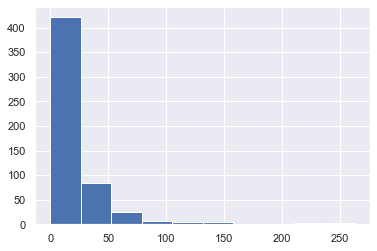

In [29]:
plt.hist(train_s0['Fare'])

### embarked（Port of Embarkation）

In [30]:
print('生き残り：C = Cherbourg→',len(train_s1[train_s1['Embarked']=='C']))
print('生き残り：Q = Queenstown→',len(train_s1[train_s1['Embarked']=='Q']))
print('生き残り：S = Southampton→',len(train_s1[train_s1['Embarked']=='S']))

生き残り：C = Cherbourg→ 93
生き残り：Q = Queenstown→ 30
生き残り：S = Southampton→ 217


In [31]:
print('死亡：C = Cherbourg→',len(train_s0[train_s0['Embarked']=='C']))
print('死亡：Q = Queenstown→',len(train_s0[train_s0['Embarked']=='Q']))
print('死亡：S = Southampton→',len(train_s0[train_s0['Embarked']=='S']))

死亡：C = Cherbourg→ 75
死亡：Q = Queenstown→ 47
死亡：S = Southampton→ 427


# 前処理

## 欠損地処理

In [32]:
train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

In [33]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### ageの欠損値処理

In [34]:
train['Age'] = train['Age'].fillna(train['Age'].median())

In [35]:
test['Age'] = test['Age'].fillna(test['Age'].median())

In [36]:
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## 文字列データを数値に変換

In [37]:
# male=0,female=1に変換
train['Sex'][train['Sex'] == 'male'] = 0
train['Sex'][train['Sex'] == 'female'] = 1
test['Sex'][test['Sex'] == 'male'] = 0
test['Sex'][test['Sex'] == 'female'] = 1

C:\Users\09de1\AppData\Local\Temp\ipykernel_13948\2262783174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sex'][train['Sex'] == 'male'] = 0
C:\Users\09de1\AppData\Local\Temp\ipykernel_13948\2262783174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sex'][train['Sex'] == 'female'] = 1
C:\Users\09de1\AppData\Local\Temp\ipykernel_13948\2262783174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Sex'][test

In [38]:
train['Sex']

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    1
889    0
890    0
Name: Sex, Length: 891, dtype: object

In [39]:
# S(Southampton)=0,C(Cherbourg)=1, Q(Queenstown)=2
train["Embarked"][train["Embarked"] == "S" ] = 0
train["Embarked"][train["Embarked"] == "C" ] = 1
train["Embarked"][train["Embarked"] == "Q"] = 2
test["Embarked"][test["Embarked"] == "S" ] = 0
test["Embarked"][test["Embarked"] == "C" ] = 1
test["Embarked"][test["Embarked"] == "Q"] = 2

C:\Users\09de1\AppData\Local\Temp\ipykernel_13948\3827633073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Embarked"][train["Embarked"] == "S" ] = 0
C:\Users\09de1\AppData\Local\Temp\ipykernel_13948\3827633073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Embarked"][train["Embarked"] == "C" ] = 1
C:\Users\09de1\AppData\Local\Temp\ipykernel_13948\3827633073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr

In [40]:
train = train.fillna({'Embarked': 0})
train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Survived         0
dtype: int64

In [41]:
train['Sex'] = train['Sex'].astype(int)
train['Embarked'] = train['Embarked'].astype(int)

In [42]:
train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1
2,3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1
4,5,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0


In [43]:
features_col = ['Pclass', 'Age', 'Sex', 'Fare', 'SibSp', 'Parch', 'Embarked']

train_y = train['Survived'].values
train_X = train[features_col].values

In [44]:
print(train_y.shape)
print(train_X.shape)

(891,)
(891, 7)


## 変数間の相関を可視化

### 相関係数が-0.7以下、または0.7以上のものは相関高い？

<AxesSubplot:>

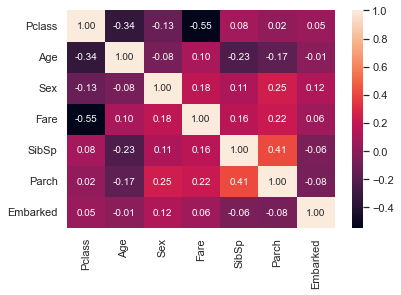

In [45]:
# 分散・共分散行列を見やすいヒートマップ形式にて出力
sns.heatmap(train[features_col].corr(), annot=True, fmt='.2f')

# xgboost

## GridSearchCVによるパラメータチューニング

In [46]:
from xgboost import XGBClassifier

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
parameters = {
    'n_estimators':[i for i in range(10, 100, 10)],
    'learning_rate':[10, 1, 0.1, 0.01],
    'max_depth':[i for i in range(1, 5, 1)],
    'random_state':[3],
}

In [49]:
# parameters ={'max_depth':[3,4,5,6,7,8],
#             'min_child_weight':[1,2,3,4,5],
#             'gamma':[i/10.0 for i in range(0,6)],
#             'subsample':[i/10.0 for i in range(6,11)],
#             'colsample_bytree':[i/10.0 for i in range(6,11)],
#             'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
#             'n_estimators':[1000,2000],
#             'reg_lambda':[1e-5, 1e-2, 0.1, 1],
#             'learning_rate':[0.1,0.2,0.3]
#             }

In [50]:
clf = GridSearchCV(XGBClassifier(), parameters, cv=5)

In [51]:
# clf.fit(train_X, train_y)

In [52]:
# clf.best_params_

In [53]:
# clf.best_score_

In [54]:
from xgboost import XGBClassifier

In [55]:
model_XGB = XGBClassifier(max_depth=2, learning_rate=1, n_estimators=60, random_state=3)

In [56]:
model_XGB.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learning_rate=1,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=60, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0, reg_lambda=1, ...)

In [57]:
model_XGB.score(train_X, train_y)

0.9079685746352413

## 予測

In [58]:
test_X = test[features_col].values

In [59]:
prediction = model_XGB.predict(test_X)

In [60]:
prediction.shape

(418,)

In [61]:
print(prediction)

[0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1
 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 1]


## 学習モデルの評価

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
from sklearn.metrics import accuracy_score

In [64]:
#訓練・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, shuffle=True)

In [65]:
y_pred_train = model_XGB.predict(X_train)
y_pred_test = model_XGB.predict(X_test)

# Accuracy の計算
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print('Accuracy(train):', acc_train)
print('Accuracy(test):', acc_test)

Accuracy(train): 0.9129213483146067
Accuracy(test): 0.888268156424581


In [66]:
sub = pd.read_csv('gender_submission.csv', index_col=None)
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [67]:
sub['Survived'] = prediction

In [68]:
sub.to_csv('titanic_xgboost.csv', index=False)

## 特徴量の重要度可視化

### 可視化①

<BarContainer object of 7 artists>

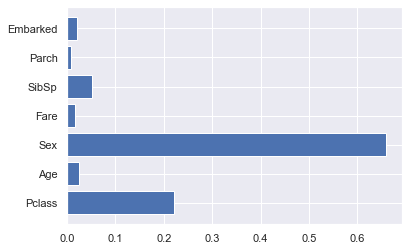

In [69]:
plt.barh(train[features_col].columns.values, model_XGB.feature_importances_)

### 可視化②

<AxesSubplot:>

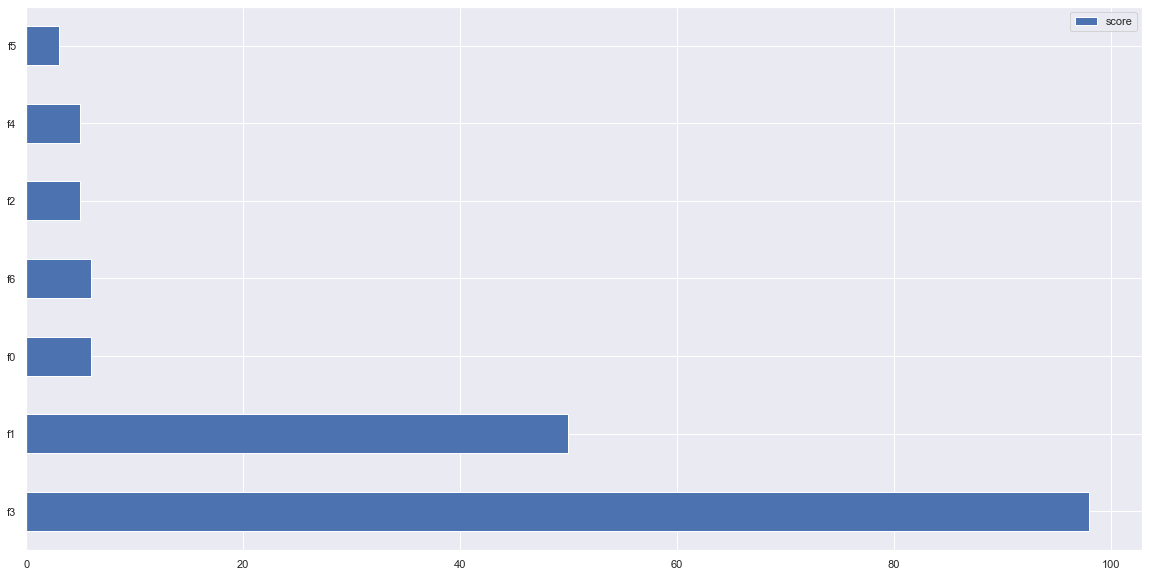

In [70]:
feature_important = model_XGB.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

### 可視化③

In [71]:
from xgboost import plot_importance

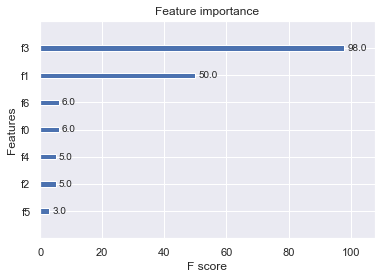

In [72]:
plot_importance(model_XGB)
plt.show()

### 可視化④

In [73]:
feature_imp = pd.Series(model_XGB.feature_importances_, index=train[features_col].columns.values).sort_values(ascending=False)

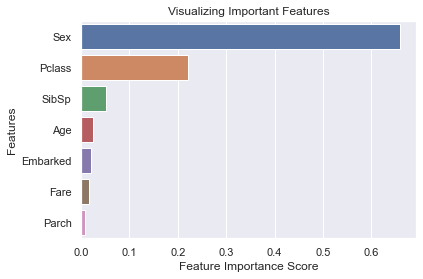

In [74]:
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### 可視化⑤

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

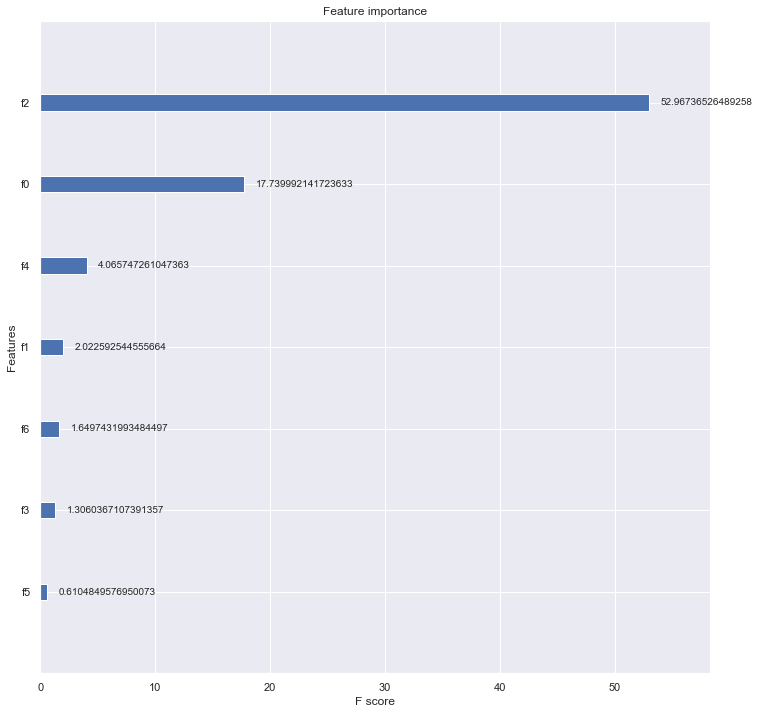

In [75]:
_, ax = plt.subplots(figsize=(12, 12))
plot_importance(model_XGB.get_booster(),
                ax=ax,
                importance_type='gain')

### 可視化⑥

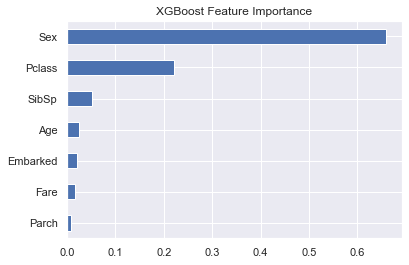

In [76]:
importances = pd.Series(model_XGB.feature_importances_, index=train[features_col].columns.values)
importances = importances.sort_values()
importances.plot(kind = 'barh')
plt.title('XGBoost Feature Importance')
plt.show()

## 決定木の可視化

### 可視化①

In [77]:
from dtreeviz.trees import *

In [78]:
import graphviz

In [79]:
type(train[features_col])

pandas.core.frame.DataFrame

In [80]:
viz = dtreeviz(model_XGB,
               x_data=train[features_col],
               y_data=train['Survived'],
               target_name='y',
               feature_names=train[features_col].columns.tolist(),
               tree_index=0)

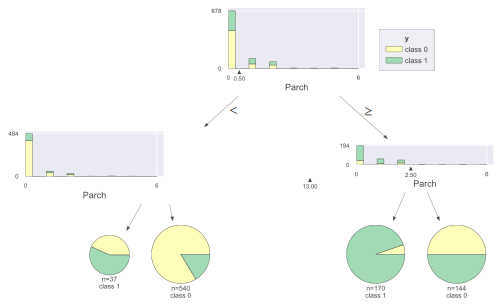

In [81]:
display(viz)

### 可視化②

In [82]:
from xgboost import plot_tree

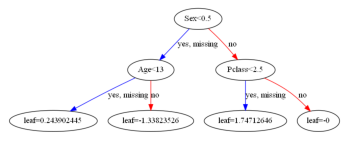

In [83]:
plot_tree(model_XGB, figsize=(20, 20))
plt.show()

### 可視化③

In [84]:
import xgboost as xgb

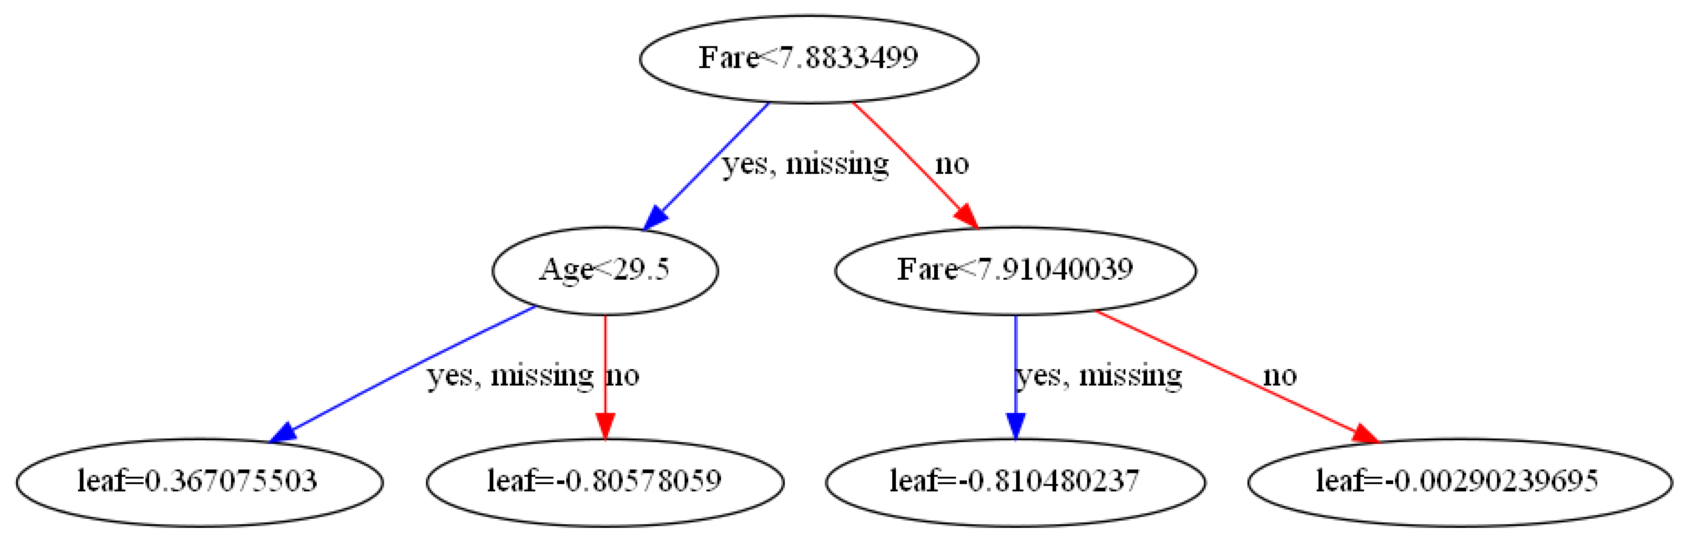

In [85]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(model_XGB, num_trees=10, ax=ax)
plt.show()

### 可視化④

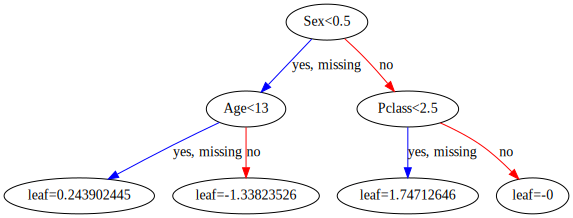

In [86]:
xgb.to_graphviz(model_XGB, num_trees=0)

# LightGBM

処理速度 → LightGBM > XGBoost > catboost

LightGBMはカテゴリー変数を扱えるが、XGBoostはカテゴリー変数を扱えない

## GridSearchCVによるパラメータチューニング

In [87]:
import lightgbm as lgbm

In [88]:
from lightgbm import LGBMClassifier

In [89]:
train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1
2,3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1
4,5,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,NaN,0,0
887,888,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,0,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,NaN,0,0
889,890,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,1,1


In [90]:
train[features_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Age       891 non-null    float64
 2   Sex       891 non-null    int32  
 3   Fare      891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Embarked  891 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 41.9 KB


In [91]:
train_y = train['Survived'].values
train_X = train[features_col].values

In [92]:
train_y.shape

(891,)

In [93]:
train_X.shape

(891, 7)

In [94]:
parameters = {"max_depth": [10, 25, 50, 75],
              "learning_rate" : [0.001,0.01,0.05,0.1],
              "num_leaves": [100,300,900,1200],
              "n_estimators": [100,200,500]
             }

In [95]:
clf = GridSearchCV(LGBMClassifier(), parameters, cv=5)

In [96]:
# clf.fit(train_X, train_y)

In [97]:
# clf.best_params_

In [98]:
# clf.best_score_

In [99]:
from lightgbm import LGBMClassifier

In [100]:
model_LGBM = LGBMClassifier(max_depth=25, learning_rate=0.01, n_estimators=500, num_leaves=100)

In [101]:
model_LGBM.fit(train_X, train_y)

LGBMClassifier(learning_rate=0.01, max_depth=25, n_estimators=500,
               num_leaves=100)

In [102]:
model_LGBM.score(train_X, train_y)

0.9034792368125701

In [103]:
train['Survived'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Survived
Non-Null Count  Dtype
--------------  -----
891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


In [104]:
train[features_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Age       891 non-null    float64
 2   Sex       891 non-null    int32  
 3   Fare      891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Embarked  891 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 41.9 KB


## 予測

In [105]:
prediction = model_LGBM.predict(test_X)

In [106]:
prediction.shape

(418,)

In [107]:
print(prediction)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 1]


## 学習モデルの評価

In [108]:
#訓練・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, shuffle=True)

In [109]:
y_pred_train = model_LGBM.predict(X_train)
y_pred_test = model_LGBM.predict(X_test)

# Accuracy の計算
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print('Accuracy(train):', acc_train)
print('Accuracy(test):', acc_test)

Accuracy(train): 0.9058988764044944
Accuracy(test): 0.8938547486033519


In [110]:
sub['Survived'] = prediction

In [111]:
sub.to_csv('titanic_lightgbm.csv', index=False)

## 特徴量の重要度可視化

### 可視化①

<BarContainer object of 7 artists>

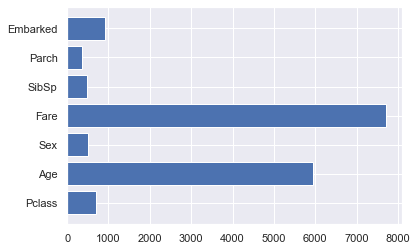

In [112]:
plt.barh(train[features_col].columns.values, model_LGBM.feature_importances_)

### 可視化②

In [113]:
feature_imp = pd.Series(model_LGBM.feature_importances_, index=train[features_col].columns.values).sort_values(ascending=False)

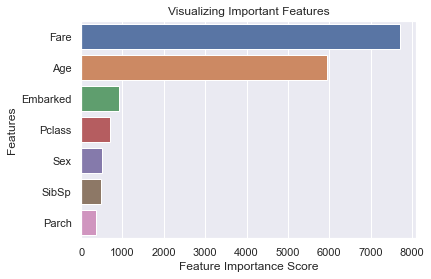

In [114]:
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

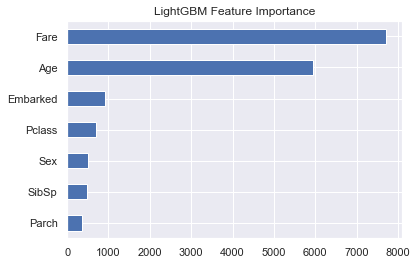

In [115]:
importances = pd.Series(model_LGBM.feature_importances_, index=train[features_col].columns.values)
importances = importances.sort_values()
importances.plot(kind = 'barh')
plt.title('LightGBM Feature Importance')
plt.show()

## 決定木の可視化

### 可視化①

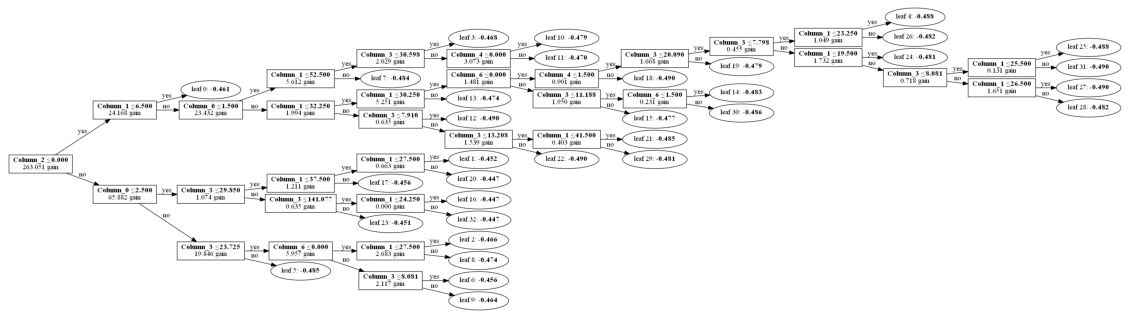

In [116]:
ax = lgbm.plot_tree(model_LGBM, tree_index=0, figsize=(20, 20), show_info=['split_gain'])
plt.show()
graph = lgbm.create_tree_digraph(model_LGBM, tree_index=0, format='png', name='Tree')

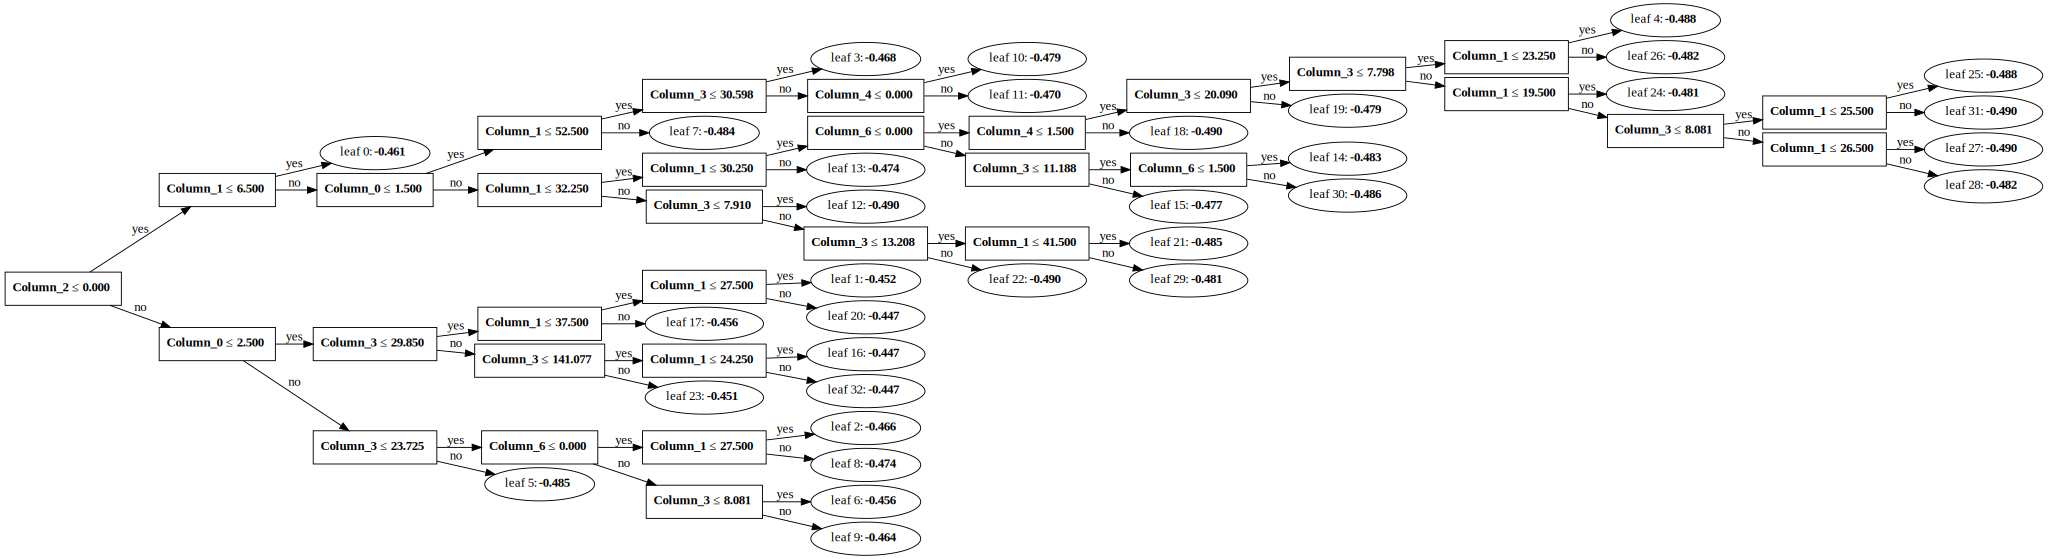

In [117]:
display(graph)

## 生存確率を出力

In [118]:
import lightgbm as lgb

In [119]:
train_y = train['Survived']
train_X = train[features_col]

In [120]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Age       891 non-null    float64
 2   Sex       891 non-null    int32  
 3   Fare      891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Embarked  891 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 41.9 KB


In [121]:
#訓練・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, shuffle=True)

In [122]:
train_set = lgb.Dataset(X_train, y_train)
valid_set = lgb.Dataset(X_test, y_test)

In [123]:
params = {
    "objective" : "binary",
    "metric" : "binary_logloss"
}

In [124]:
result_data = {}
model = lgb.train(
    params = params,
    train_set = train_set,
    valid_sets = [train_set, valid_set],
    num_boost_round = 100,
    early_stopping_rounds = 5,
    verbose_eval = 50,
    evals_result = result_data
)

[LightGBM] [Info] Number of positive: 278, number of negative: 434
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390449 -> initscore=-0.445423
[LightGBM] [Info] Start training from score -0.445423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation(

In [125]:
pred = model.predict(test_X)
print(pred)

[0.05625958 0.38926843 0.1327708  0.27135602 0.59311933 0.22820434
 0.77532881 0.23956489 0.78296818 0.04955816 0.10165435 0.21195433
 0.93686453 0.06024094 0.94716746 0.87472022 0.15147381 0.18595175
 0.30133727 0.74513948 0.54084849 0.35947754 0.94806148 0.34396089
 0.92688035 0.08586416 0.92906484 0.18595175 0.39545361 0.11714438
 0.06594118 0.05591069 0.46623767 0.25555103 0.57595238 0.15976948
 0.27579031 0.35157124 0.09265572 0.50163192 0.10001211 0.62849034
 0.06997308 0.83308299 0.94716746 0.25122766 0.39650852 0.18921212
 0.94716746 0.51767901 0.53735576 0.24209943 0.88728922 0.92688035
 0.17607129 0.04980408 0.04748832 0.23138631 0.17367555 0.92688035
 0.08828932 0.31810739 0.15173679 0.8098202  0.4282072  0.81081666
 0.80279727 0.18177767 0.51433551 0.92688035 0.77532881 0.08599937
 0.30133727 0.41658465 0.92688035 0.47931043 0.26596022 0.83871681
 0.25541266 0.77532881 0.84363839 0.44553602 0.21195433 0.10165435
 0.18711037 0.26868468 0.76739803 0.35157124 0.77532881 0.8651

In [126]:
test_ = test.copy()
test_['Survived'] = pred
test_.sort_values(by="Survived",ascending=False) 

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
371,1263,1,"Wilson, Miss. Helen Alice",1,31.0,0,0,16966,134.5000,E39 E41,1,0.948202
361,1253,2,"Mallet, Mrs. Albert (Antoinette Magnin)",1,24.0,1,1,S.C./PARIS 2079,37.0042,NaN,1,0.948061
385,1277,2,"Herman, Miss. Kate",1,24.0,1,2,220845,65.0000,NaN,0,0.948061
364,1256,1,"Harder, Mrs. George Achilles (Dorothy Annan)",1,25.0,1,0,11765,55.4417,E50,1,0.948061
92,984,1,"Davidson, Mrs. Thornton (Orian Hays)",1,27.0,1,2,F.C. 12750,52.0000,B71,0,0.948061
...,...,...,...,...,...,...,...,...,...,...,...,...
337,1229,3,"Elias, Mr. Joseph",0,39.0,0,2,2675,7.2292,NaN,1,0.042680
123,1015,3,"Carver, Mr. Alfred John",0,28.0,0,0,392095,7.2500,NaN,0,0.040652
152,1044,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,0,0.038000
285,1177,3,"Dennis, Mr. William",0,36.0,0,0,A/5 21175,7.2500,NaN,0,0.034378


In [127]:
print('平均生存確率（予測）：',round(test_['Survived'].mean()*100,2), '%')

平均生存確率（予測）： 41.48 %


In [128]:
print('生存率（予測データ）：',round(sub['Survived'].mean()*100,2),'%')

生存率（予測データ）： 35.65 %


In [129]:
print('生存率（学習データ）：',round(train['Survived'].mean()*100,2),'%')

生存率（学習データ）： 38.38 %
